# Examining Telemarketing Data
 
Please see <code>db.py</code> and <code>processing.py</code> for the implentation of database and processing related utilities used in this notebook.

In [1]:
from db import Database
import processing as proc
from pathlib import Path
import time
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.neighbors import (KNeighborsClassifier,NeighborhoodComponentsAnalysis)
from sklearn.pipeline import Pipeline
import sklearn
import pickle

logger = proc.setupLog()
figureCount=0
records = Database('bank_data')


### Taking a look
We begin by checking the frequency of the target, <code>y</code>, which denotes whether or not a purchase was made.
We can see that our data is imbalaced, with about nine examples with <code>y=0</code> to each one <code>y=1</code>.

There are two seperate datasets here, both have the same target, with one having a few extra features, they are primarily economic indicators at the time of contact.  The datasets were taken from UCI's machine learning repository linked [here](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing).




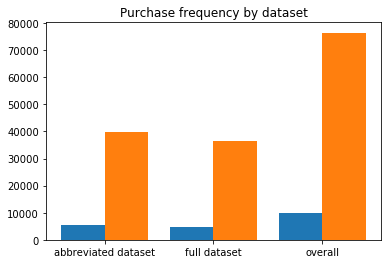

In the abbreviated dataset a purchase occured 11.70% of the time.
In the full dataset a purchase occured 11.27% of the time.
In the combined dataset a purchase occured 11.49% of the time.


In [2]:
numPeople = records.getSize('people')
numPeopleA = records.getSize('people_additional')
results = records.getEntriesByField('people',0,numPeople,'y')
resultsA = records.getEntriesByField('people_additional',0,numPeopleA,'y')
##tally up number of Y/N s
peopleBuy = 0
for char in results:
    if char == 'Y': peopleBuy+=1
peopleBuyA = 0
for char in resultsA:
    if char == 'Y': peopleBuyA+=1

buys = (peopleBuy,peopleBuyA,peopleBuy+peopleBuyA)
notBuys = (numPeople-buys[0],numPeopleA-buys[1],numPeople+numPeopleA-buys[2])

##Plot
ind = [ i for i in range(len(buys)) ]
width = .4
plt.figure(figureCount)
figureCount+=1
plt.bar(ind,buys,width,label= 'Purchase')
plt.bar([item+width for item in ind],notBuys,width,label='No Purchase')
plt.title('Purchase frequency by dataset')
plt.xticks([item+width/2 for item in ind],('abbreviated dataset','full dataset', 'overall'))
plt.show()

print("In the abbreviated dataset a purchase occured {:.2f}% of the time.".format(
     ( float(buys[0])/float(numPeople) )*100 ) )
print("In the full dataset a purchase occured {:.2f}% of the time.".format(
     ( float(buys[1])/float(numPeopleA) )*100 ) )
print("In the combined dataset a purchase occured {:.2f}% of the time.".format(
     ( float(buys[2])/float(numPeople+numPeopleA) )*100 ) )

### Getting our dataset ready for processing
The dataset has been extracted from csv, translated for efficient storage (strings mapped to characters etc.) and loaded into a MySQL database.
Below is a few of the fetched SQL entries and human-readable dataframes lines.  For completeness, a single final encoding of the ready-for-work numpy vector is also displayed.
*Note: We remove the <code>duration</code> field as reccomended in the dataset posting.  See the link above for more information.*



In [3]:
#get data dictionaries for processing
peopleMap, peopleAdditionalMap = records.getMaps()

#sql entries
line = records.getEntries('people',0,numPeople)

print('First 5 of the sql entries:')
for i in range(5):
    print(line[i])
    
#translate to human-readable dataframe (similar to original csv)
df = proc.getDataFrame(line,peopleMap)
print('\n\nHead of the dataframe:')
print(df.head())

#see validate for more details, basically ensures all categories accounted for properly
proc.validate(df,peopleMap)
vec = proc.getOneHot(df,peopleMap,False)

#duration is not known until outcome is known
#see dataset documentation for more info
vec = vec.drop('duration',axis=1)
dataOneHot = vec.to_numpy(dtype=np.float64)

print('\n\nFinally, here is a single vector ready for processing:')
print(dataOneHot[0])


#do the same as above for tha additional dataset
lineA = records.getEntries('people_additional',0,numPeopleA)
dfa = proc.getDataFrame(lineA,peopleAdditionalMap)
proc.validate(dfa,peopleAdditionalMap)
vecA = proc.getOneHot(dfa,peopleAdditionalMap,False)
vecA = vecA.drop('duration',axis=1)
dataOneHotA = vecA.to_numpy(dtype=np.float64)

#get column labels
colTitles = vec.columns
colTitlesA = vecA.columns

#rand generator
randomGenr = np.random.default_rng()

First 5 of the sql entries:
(58, 'M', 'M', 'T', 'N', 2143, 'Y', 'N', '?', 5, 5, 261, 1, -1, 0, '?', 'N')
(44, 'T', 'S', 'S', 'N', 29, 'Y', 'N', '?', 5, 5, 151, 1, -1, 0, '?', 'N')
(33, 'E', 'M', 'S', 'N', 2, 'Y', 'Y', '?', 5, 5, 76, 1, -1, 0, '?', 'N')
(47, 'B', 'M', '?', 'N', 1506, 'Y', 'N', '?', 5, 5, 92, 1, -1, 0, '?', 'N')
(33, '?', 'S', '?', 'N', 1, 'N', 'N', '?', 5, 5, 198, 1, -1, 0, '?', 'N')


Head of the dataframe:
   age           job  marital  education isDefault  balance housing loan  \
0   58    management  married   tertiary        no     2143     yes   no   
1   44    technician   single  secondary        no       29     yes   no   
2   33  entrepreneur  married  secondary        no        2     yes  yes   
3   47   blue-collar  married    unknown        no     1506     yes   no   
4   33       unknown   single    unknown        no        1      no   no   

   contact  day  month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5      5       261        

### Getting organized

Here we seperate the testing and training sets, create a seperate feauture set which is scaled to the standard normal distribution, and organize our models.

STUFF AND LINK is used for scaling, models, etc

In [4]:
randomGenr.shuffle(dataOneHot)
randomGenr.shuffle(dataOneHotA)
    
#extract features, set float
features = dataOneHot[:,:-1].astype(np.float64)
featuresA = dataOneHotA[:,:-1].astype(np.float64)
#extract labels
labels = dataOneHot[:,-1]
labelsA = dataOneHotA[:,-1]    
#get ~20% of indices as random choice WITHOUT replacement for test
testIndices = randomGenr.choice(len(labels),size=int(len(labels)*.1),replace=False)
testIndicesA = randomGenr.choice(len(labelsA),size=int(len(labelsA)*.1),replace=False)
#take test items
testLabels = np.take(labels,testIndices)
testFeatures = np.take(features,testIndices,axis=0)
testLabelsA = np.take(labelsA,testIndicesA)
testFeaturesA = np.take(featuresA,testIndicesA,axis=0)
#remove test items
trainLabels = np.delete(labels,testIndices)
trainFeatures = np.delete(features,testIndices,axis=0)
trainLabelsA = np.delete(labelsA,testIndicesA)
trainFeaturesA = np.delete(featuresA,testIndicesA,axis=0)

#initialize models
rafo = RandomForestClassifier(n_estimators=500,class_weight='balanced')
rafoA = RandomForestClassifier(n_estimators=500,class_weight='balanced')
mlp = MLPClassifier(max_iter=500)
mlpA = MLPClassifier(max_iter=500)
knn = KNeighborsClassifier(9)
knnA = KNeighborsClassifier(11)


####

models = { 'RAFO': (rafo,rafoA),#random forest
          'MLP' : (mlp,mlpA),   #multi level perceptron
          'KNN': (knn,knnA)     #k nearest neighbor
         }

#initialize models
rafoS = RandomForestClassifier(n_estimators=500,class_weight='balanced')
rafoAS = RandomForestClassifier(n_estimators=500,class_weight='balanced')
mlpS = MLPClassifier(max_iter=500)
mlpAS = MLPClassifier(max_iter=500)
knnS = KNeighborsClassifier(9)
knnAS = KNeighborsClassifier(11)

####

modelsScaled = { 'RAFO': (rafoS,rafoAS),#random forest
                 'MLP' : (mlpS,mlpAS),  #multi level perceptron
                 'KNN' : (knnS,knnAS)   #k nearest neighbor
                } 

results = {key:dict() for key in models.keys()}
resultsScaled = {key:dict() for key in modelsScaled.keys()}
results['labels'] = (testLabels,testLabelsA)
#no need to scale labels
resultsScaled['labels'] = (testLabels,testLabelsA)

#create scaled features
scaler = sklearn.preprocessing.StandardScaler()
trainFeaturesS = scaler.fit_transform(trainFeatures)
testFeaturesS = scaler.fit_transform(testFeatures)
trainFeaturesAS = scaler.fit_transform(trainFeaturesA)
testFeaturesAS = scaler.fit_transform(testFeaturesA)



In [ ]:
for name,model,modelS in zip(models.keys(),models.values(),modelsScaled.values()):
    print('running '+name)
    model[0].fit(trainFeatures,trainLabels)
    model[1].fit(trainFeaturesA,trainLabelsA)
    modelS[0].fit(trainFeaturesS,trainLabels)
    modelS[1].fit(trainFeaturesAS,trainLabelsA)
    
    #get predictions
    preds = model[0].predict(testFeatures)
    predsA = model[1].predict(testFeaturesA)
    predsS = modelS[0].predict(testFeaturesS)
    predsAS = modelS[1].predict(testFeaturesAS)
    results[name]['predictions'] = (preds,predsA)
    resultsScaled[name]['predictions'] = (predsS,predsAS)
    
    #get P(y=1) for each prediction
    probs = [pair[1] for pair in model[0].predict_proba(testFeatures)]
    probsA = [pair[1] for pair in model[1].predict_proba(testFeaturesA)]
    probsS = [pair[1] for pair in modelS[0].predict_proba(testFeaturesS)]
    probsAS = [pair[1] for pair in modelS[1].predict_proba(testFeaturesAS)]
    results[name]['probabilities'] = (probs,probsA)
    resultsScaled[name]['probabilities'] = (probsS,probsAS)
    
    

running RAFO
running MLP


In [ ]:
baseDir = "./results/"
Path(baseDir).mkdir(exist_ok=True)
with open(baseDir+"results.pkl","w") as file:
    pickle.dump(results,file)
    file.close()
with open(baseDir+"resultsScaled.pkl","w") as file:
    pickle.dump(resultsScaled,file)


In [ ]:
#result {model: {predictions: <VECTOR>, probabilities: <VECTOR>} }
#organize TRUE/FALSE +/- probs
#for each
#each tallys[modelName] contains a confusion-matrix-style-indexed set of list indexed by [correct][predicted]
#where the list contains the model's P(y=1)
tallys = dict()
tallysA = dict()
for key in results.keys():
    tallys[key] = [[[],[]], [[],[]]]
    tallysA[key] = [[[],[]], [[],[]]]
    i=0
    for test,pred,testA,predA in zip(testLabels,results[key]['predictions'],testLabelsA,resultsScaled['predictions']):
            tallys[key][int(test)][int(pred)].append(results[key]['probabilties'][i])
            tallysA[key][int(testA)][int(predA)].append(resultsScaled[key]['probabilities'][i])


#count wrong predictions
correct = [(sum(tallys[key][0][0])+sum(tally[key][1][1])) for key in tallys.keys()]
wrong = [(sum(tallys[key][1][0])+sum(tally[key][0][1])) for key in tallys.keys()]
ind = [ i for i in range(len(correct)) ]
width = .4
plt.figure(figureCount)
figureCount+=1
plt.bar(ind,correct,width,label= 'Corect Prediction',color='green')
plt.bar([item+width for item in ind],wrong,width,label='Incorrect Predictions',color='red')
plt.title('Prediction success for abbreviated dataset')
plt.legend()
plt.xticks([item+width/2 for item in ind],[name for name in range models.keys()])
plt.show()
